<a href="https://colab.research.google.com/github/Aditya6122/Drone-View-Object-Detection/blob/HyperParameter-Tuning-and-Backbone-settings/(Custom_Backbone)_Working_Finetuning_on_object_detection_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!rm -rf /content/data_13
!cp -r /content/drive/MyDrive/Objectdetection/data_13 /content

In [3]:
!rm -rf /content/data_13/.ipynb_checkpoints
!rm -rf /content/data_13/test/.ipynb_checkpoints
!rm -rf /content/data_13/train/.ipynb_checkpoints

In [1]:
import os
from torch.utils.data import Dataset
from PIL import Image
import xml.etree.ElementTree as ET
import torch
from engine import train_one_epoch, evaluate
import random
import torch
import utils
from torchvision.transforms import functional as F
from torch.utils.data import DataLoader
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.utils import draw_bounding_boxes
import transforms as T
from torchvision.models.detection import fasterrcnn_resnet50_fpn

In [2]:
class CityDataset(Dataset):
    def __init__(self,root, transforms=None):
        self.root = root
        self.transforms = transforms
        self.imgs = list(sorted(os.listdir(os.path.join(root,"images"))))
        self.annots = list(sorted(os.listdir(os.path.join(root,"annotations"))))
        self.labels =   {
            'pedestrain':1,
            'tree':2,
            'car':3,
            'motorcycle':4
        }
    
    def __getitem__(self, idx):
        img_path = os.path.join(self.root, "images", self.imgs[idx])
        annot_path = os.path.join(self.root, "annotations", self.annots[idx])
        img = Image.open(img_path).convert("RGB")
        tree = ET.parse(annot_path)
        root = tree.getroot()

        boxes = list()
        labels = list()
        for obj in root.findall('.//object'):
            label = obj.find('name').text
            box = obj.find('bndbox')
            xmin = int(box.find('xmin').text)
            ymin = int(box.find('ymin').text)
            xmax = int(box.find('xmax').text)
            ymax = int(box.find('ymax').text)
            coors = [xmin, ymin, xmax, ymax]
            boxes.append(coors)
            labels.append(self.labels[label])

        num_objs = len(labels)
        boxes = torch.as_tensor(boxes, dtype=torch.float32)
        labels = torch.as_tensor(labels, dtype=torch.int64)
        image_id = torch.tensor([idx])
        area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])
        iscrowd = torch.zeros((num_objs,), dtype=torch.int64)

        target = {}
        target["boxes"] = boxes
        target["labels"] = labels
        target["image_id"] = image_id
        target["area"] = area
        target["iscrowd"] = iscrowd

        if self.transforms is not None:
            img, target = self.transforms(img, target)

        return img, target

    def __len__(self):
        return len(self.imgs)

In [3]:
def collate_fn(batch):
    return tuple(zip(*batch))

In [4]:
def get_transform(train):
    transforms = []
    transforms.append(T.ToTensor())
    if train:
        transforms.append(T.RandomHorizontalFlip(0.5))
    return T.Compose(transforms)

In [5]:
################### dev ##############################
import torchvision
import torch

backbone = torchvision.models.mobilenet_v2().features
backbone_layers = list(backbone.children())[:-5]
backbone_layers.append(list(backbone.children())[-1])
backbone = torch.nn.Sequential(*backbone_layers)

In [6]:
backbone_residual_outftrs = backbone[-2].conv[3].num_features

In [7]:
backbone[-1][0].in_channels = backbone_residual_outftrs
backbone[-1][0].out_channels = 256 
backbone[-1][1].num_features = 256
backbone.out_channels = 256
backbone[-1][0].weight.data = torch.nn.init.xavier_uniform_(torch.empty(256,96,1,1), gain=torch.nn.init.calculate_gain('relu'))
backbone[-1][1] = torch.nn.BatchNorm2d(256)

In [10]:
import torchvision
from torchvision.models.detection import FasterRCNN
from torchvision.models.detection.rpn import AnchorGenerator
import torch

anchor_generator = AnchorGenerator(sizes=((8,16,32,64),),
                                   aspect_ratios=((0.25,0.5,1.0,2.0),))

roi_pooler = torchvision.ops.MultiScaleRoIAlign(featmap_names=['0','1','3'],
                                                output_size=7,
                                                sampling_ratio=2)
model = FasterRCNN(backbone,
                   num_classes=5,
                   rpn_anchor_generator=anchor_generator,
                   box_roi_pool=roi_pooler)

In [11]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

dataset = CityDataset('/content/data_13/train', get_transform(train=True))
dataset_test = CityDataset('/content/data_13/test', get_transform(train=False))

data_loader = torch.utils.data.DataLoader(
    dataset, batch_size=8, shuffle=True, num_workers=4,
    collate_fn=collate_fn)

data_loader_test = torch.utils.data.DataLoader(
    dataset_test, batch_size=3, shuffle=False, num_workers=4,
    collate_fn=collate_fn)

model.to(device)

params_backbone = [param for name,param in model.named_parameters() if param.requires_grad and 'backbone' in name ]
params_other = [param for name,param in model.named_parameters() if param.requires_grad and 'backbone' not in name]

optimizer = torch.optim.SGD([
                {'params': params_backbone, 'lr':5e-1,'momentum':0.9,'weight_decay':0.00005},
                {'params': params_other}
            ], lr=5e-1, momentum=0.09,weight_decay=0.000005)

lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer,step_size=3, gamma=0.1)

num_epochs = 4

for epoch in range(num_epochs):
    train_one_epoch(model, optimizer, data_loader, device, epoch, print_freq=10)
    lr_scheduler.step()
    evaluate(model, data_loader_test, device=device)


Epoch: [0]  [ 0/16]  eta: 0:00:19  lr: 0.033800  loss: 2.9215 (2.9215)  loss_classifier: 1.5926 (1.5926)  loss_box_reg: 0.0035 (0.0035)  loss_objectness: 0.6923 (0.6923)  loss_rpn_box_reg: 0.6330 (0.6330)  time: 1.1942  data: 0.6228  max mem: 7768
Epoch: [0]  [10/16]  eta: 0:00:03  lr: 0.366800  loss: 2.3676 (2.3642)  loss_classifier: 1.0259 (1.0775)  loss_box_reg: 0.0569 (0.0633)  loss_objectness: 0.6876 (0.6835)  loss_rpn_box_reg: 0.4498 (0.5399)  time: 0.5771  data: 0.0769  max mem: 7768
Epoch: [0]  [15/16]  eta: 0:00:00  lr: 0.500000  loss: 1.9060 (2.0985)  loss_classifier: 0.8709 (0.8542)  loss_box_reg: 0.0671 (0.0680)  loss_objectness: 0.6763 (0.6691)  loss_rpn_box_reg: 0.4498 (0.5072)  time: 0.5500  data: 0.0604  max mem: 7768
Epoch: [0] Total time: 0:00:09 (0.5673 s / it)
creating index...
index created!
Test:  [0/4]  eta: 0:00:01  model_time: 0.0659 (0.0659)  evaluator_time: 0.0031 (0.0031)  time: 0.4258  data: 0.3513  max mem: 7768
Test:  [3/4]  eta: 0:00:00  model_time: 0.04

In [17]:
backbone

Sequential(
  (0): Conv2dNormActivation(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU6(inplace=True)
  )
  (1): InvertedResidual(
    (conv): Sequential(
      (0): Conv2dNormActivation(
        (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
        (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU6(inplace=True)
      )
      (1): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
  )
  (2): InvertedResidual(
    (conv): Sequential(
      (0): Conv2dNormActivation(
        (0): Conv2d(16, 96, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (

In [ ]:
import time

def get_inference(img_path,threshold,model):
    start = time.time()
    img = Image.open(img_path).convert("RGB")
    img = torchvision.transforms.PILToTensor()(img)
    print(img.size())

    model.eval()
    with torch.no_grad():
        prediction = model([(img/255).to(device)])
        
    labels =   {
            1:'person',
            2:'tree',
            3:'car',
            4:'motorcycle'
        }

    predictions = []
    for i in prediction[0]['labels'].tolist():
        predictions.append(labels[i])

    scores = prediction[0]['scores'].tolist()
    print(scores)
    idx = next(x for x, val in enumerate(scores) if val < threshold)
    output = draw_bounding_boxes(img.to(torch.uint8), prediction[0]['boxes'][:idx], predictions[:idx])
    out = torchvision.transforms.ToPILImage()(output) 
    end = time.time()
    time_taken = end-start
    return out,time_taken

torch.Size([3, 512, 512])
[0.4187511205673218, 0.41271212697029114, 0.361767441034317, 0.3468298316001892, 0.33802592754364014, 0.33603769540786743, 0.30385494232177734, 0.29953885078430176, 0.29914167523384094, 0.2963429093360901, 0.29369163513183594, 0.28756511211395264, 0.2849433422088623, 0.27341312170028687, 0.2598438560962677, 0.2583290934562683, 0.25501689314842224, 0.2537844181060791, 0.252758651971817, 0.2524489462375641, 0.2483617514371872, 0.2475351244211197, 0.24130304157733917, 0.24031446874141693, 0.2395031750202179, 0.23840972781181335, 0.23398415744304657, 0.23371601104736328, 0.23361630737781525, 0.22933927178382874, 0.22408339381217957, 0.22379569709300995, 0.2234993875026703, 0.22258329391479492, 0.22239965200424194, 0.2215966135263443, 0.21888479590415955, 0.2172601968050003, 0.21592186391353607, 0.2153337448835373, 0.21189361810684204, 0.21178624033927917, 0.21175551414489746, 0.2105592042207718, 0.21052657067775726, 0.20997770130634308, 0.2094447910785675, 0.20932

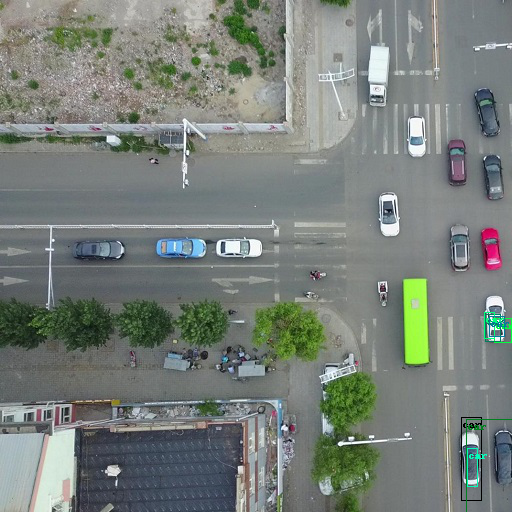

In [ ]:
img, time_taken = get_inference('/content/test1.jpg', 0.3, model)
print(time_taken)
img.show()

In [ ]:
# torch.save(model.state_dict(), '/content/model_best_current.pt')
# !cp /content/model_best_current.pt /content/drive/MyDrive/Objectdetection

In [ ]:
model1 = getDroneObjectDetectionInstance()
model1.load_state_dict(torch.load('/content/model_best_current.pt'))
model1.to(device)
model1.eval()